In [9]:
from pymatgen.core import Structure
from pymatgen.io.vasp.outputs import Xdatcar
import os
from os import path
import xml.etree.ElementTree as ET
from pymatgen.io.vasp.outputs import Vasprun
import numpy as np

In [10]:
#path to folder with DFT data
DFT_dir = '/home/e05/e05/lr508/work/Scratch/MLFF/equi_nvt/NEZC/1000K/'
struc = Structure.from_file(DFT_dir+'POSCAR')
struc_len = len(struc)


template_XDAT = Xdatcar(DFT_dir+'XDATCAR')
structures = template_XDAT.structures
print(len(structures))
rangeList = [*range(len(structures))]
indices = rangeList[1::4] # list of indices you'll be getting energies for

2000


In [11]:
#list of AIMD energies
aimd_energies_run = []

# get energies from aimd vasprun
tree = Vasprun(DFT_dir+'vasprun.xml')
data  = tree.ionic_steps

for i in data:
    e0 = (i['e_0_energy'])
    aimd_energies_run.append(e0/struc_len) #this gives you the energies in eV / atom
    # aimd_energies_run.append(e0)
print(len(aimd_energies_run))

/work/e05/e05/lr508/miniconda3/lib/python3.9/site-packages/pymatgen/io/vasp/outputs.py:148: UserWarning: Float overflow (*******) encountered in vasprun
  warnings.warn("Float overflow (*******) encountered in vasprun")
/work/e05/e05/lr508/miniconda3/lib/python3.9/site-packages/pymatgen/io/vasp/inputs.py:1737: UserWarning: Ignoring unknown variable type SHA256
  warnings.warn(f"Ignoring unknown variable type {key}")
/work/e05/e05/lr508/miniconda3/lib/python3.9/site-packages/pymatgen/io/vasp/inputs.py:1737: UserWarning: Ignoring unknown variable type COPYR
  warnings.warn(f"Ignoring unknown variable type {key}")


2000


/work/e05/e05/lr508/miniconda3/lib/python3.9/site-packages/pymatgen/io/vasp/outputs.py:408: UnconvergedVASPWarning: /home/e05/e05/lr508/work/Scratch/MLFF/equi_nvt/NEZC/1000K/vasprun.xml is an unconverged VASP run.
Electronic convergence reached: True.
Ionic convergence reached: False.
  warnings.warn(msg, UnconvergedVASPWarning)


In [12]:
ml_plot = []
aimd_plot = []
for i in indices:
    #path to MLMD vasprun
    ml_vasprun = f'/home/e05/e05/lr508/work/XDATCAR_MLFF/config_{i}/vasprun.xml'
    tree = ET.parse(ml_vasprun)
    root = tree.getroot()
     # get energies from ml vasprun
    for structure in root.findall('energy'):
        for value in structure.findall('i'):
            if 'e_0_energy' in value.attrib['name']:
                ml_plot.append(float(value.text)/struc_len) #energies in eV / atom
                # ml_plot.append(float(value.text))
    aimd_plot.append(aimd_energies_run[i])


In [13]:

print(len(ml_plot))
print(len(aimd_plot))

500
500


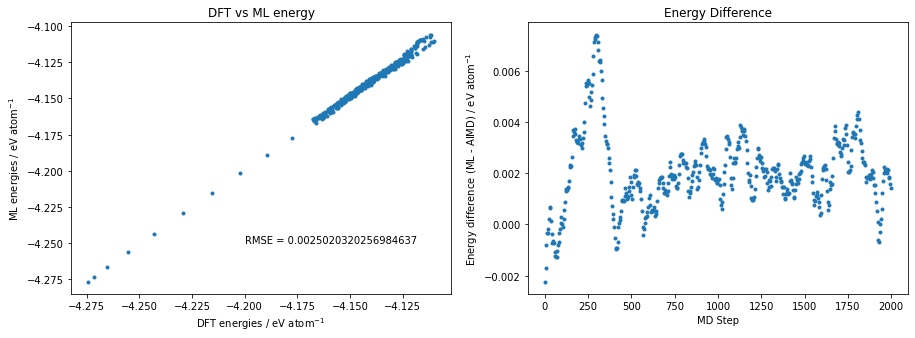

In [14]:
energies_difference = [i - j for i,j in zip(ml_plot, aimd_plot)]
import matplotlib.pyplot as plt             
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,2,1)
plt.plot(aimd_plot,ml_plot, '.')
plt.xlabel('DFT energies / eV atom$^{-1}$')
plt.ylabel('ML energies / eV atom$^{-1}$')
ml_plot = np.array(ml_plot)
aimd_plot = np.array(aimd_plot)
plt.text(-4.2,-4.25,s=f"RMSE = {np.sqrt(((ml_plot - aimd_plot) ** 2).mean())}")
# plt.text(-635,-645,s=f"RMSE = {np.sqrt(((ml_plot - aimd_plot) ** 2).mean())}")
plt.title('DFT vs ML energy')

plt.subplot(1,2,2)
plt.plot(indices,energies_difference, '.')
plt.xlabel('MD Step')
plt.ylabel('Energy difference (ML - AIMD) / eV atom$^{-1}$')
plt.title('Energy Difference')
plt.show()


In [15]:
def forces_plot(plotted_species):
    from pymatgen.core import Structure

    # finding indices of selected atom (to plot)

    structure = Structure.from_file(f'{DFT_dir}/POSCAR')
    list_species = []
    for atom in structure:
        list_species.append(atom.species_string)

    if plotted_species not in list_species:
        raise ValueError("Selected species not present in structure")
        
    plot_indices = []
    for index, atom in enumerate(list_species):
        if atom == plotted_species:
            plot_indices.append(index)

    print(f"Indices to plot = {plot_indices} (length {len(plot_indices)})")

    # create dictionary of ml forces

    ml_run = {}
    for i in indices:
        step = i
        tree = ET.parse(f'config_{i}/vasprun.xml')
        root = tree.getroot()   
        for structure in root.findall('varray'):
            if 'forces' in structure.attrib['name']:
                ml_run[step] = {}
                for atom_index,i in enumerate(structure):
                    i = str(i.text).strip()
                    i = str(i).replace("      ",',')
                    i = i.split(',')
                    forces_atom = [float(i[0]),float(i[1]),float(i[2])]
                    ml_run[step][atom_index] = np.linalg.norm(forces_atom) #add magnitude of x,y,z forces to list 
    # create dictionary of aimd forces
    tree = ET.parse(f'{DFT_dir}/vasprun.xml')
    root = tree.getroot()      
    aimd_run = {}
    step = 0
    for structure in root.findall('calculation'):
        step += 1
        for value in structure.findall('varray'):
            if 'forces' in value.attrib['name']:
                aimd_run[step] = {}
                for atom_index,i in enumerate(value):
                    i = str(i.text).strip()
                    i = str(i).replace("      ",',')
                    i = i.split(',')
                    forces_atom = [float(i[0]),float(i[1]),float(i[2])]
                    aimd_run[step][atom_index] = np.linalg.norm(forces_atom) #add magnitude of x,y,z forces to list 

    import matplotlib.pyplot as plt
    ml_f = []
    aimd_f = []
    plot_steps = []
    for step in indices:
        for atom in ml_run[step]:
            if atom in plot_indices:
                scalar_force = ml_run[step][atom]
                ml_f.append(scalar_force)
                plot_steps.append(step)

    # adds forces for the correct structures to list
    for step in indices:
        for atom in aimd_run[step]:
            if atom in plot_indices:
                scalar_force = aimd_run[step][atom]
                aimd_f.append(scalar_force)

    delta_f = [i - j for i,j in zip(ml_f,aimd_f)]

    # plt.rcParams["figure.figsize"] = (16,10)
    plt.subplot(1,2,1)
    plt.plot(aimd_f,ml_f, '.')
    plt.xlabel('DFT f / eV Å$^{-1}$')
    plt.ylabel('ML f / eV Å$^{-1}$')
    aimd_f = np.array(aimd_f)
    ml_f = np.array(ml_f)
    plt.text(1.5,0.2,f"RMSE = {np.sqrt(((ml_f - aimd_f) ** 2).mean())}")
    plt.title(f"{plotted_species} DFT vs MLFF forces")

    plt.subplot(1,2,2)
    plt.plot(plot_steps,delta_f, '.')
    plt.xlabel('Step')
    plt.ylabel('$\Delta$ f (ML - AIMD) / eV Å$^{-1}$')

    plt.title(f"{plotted_species} $\Delta F$ (ML - AIMD)")
    plt.show()

Indices to plot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] (length 40)


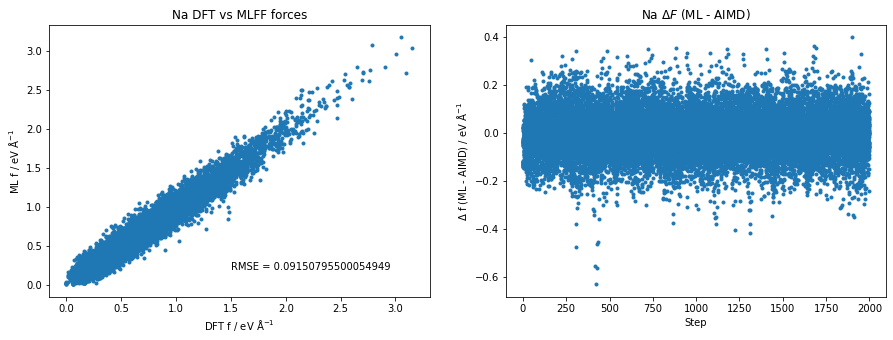

Indices to plot = [56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151] (length 96)


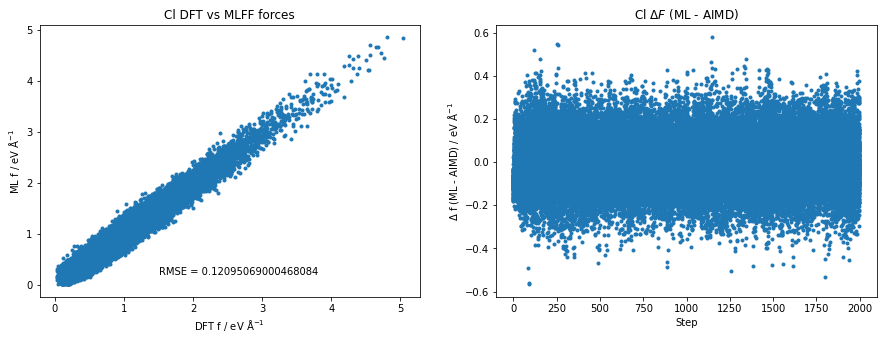

Indices to plot = [40, 41, 42, 43, 44, 45, 46, 47] (length 8)


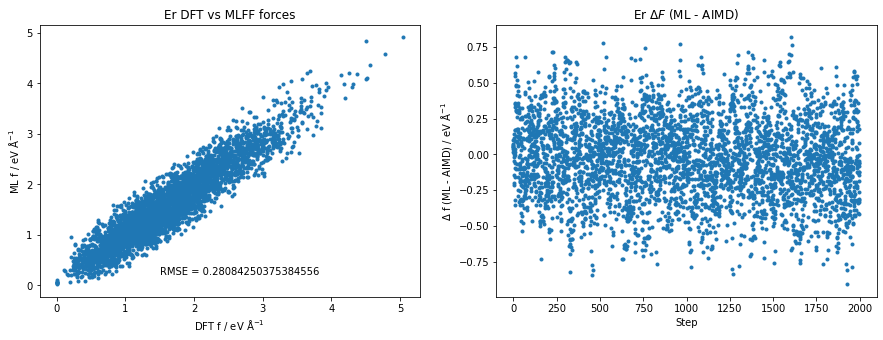

Indices to plot = [48, 49, 50, 51, 52, 53, 54, 55] (length 8)


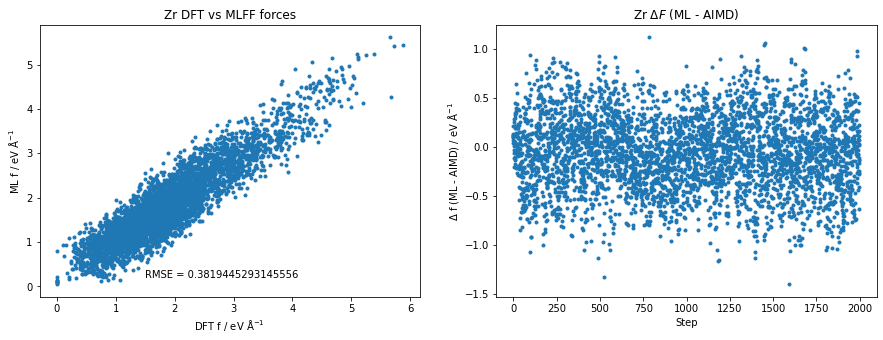

In [16]:
forces_plot('Na') #one force plot for each atom in material
forces_plot('Cl')
forces_plot('Er')
forces_plot('Zr')